# Stroke ClassificationKNN

In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Data cleaning and prep

In [28]:
stroke_df = pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [29]:
# make a copy so we keep the original data untouched
stroke_copy = stroke_df.copy()

In [34]:
# #with na's dropped we hardly lose data so we decided to just drop NA's
stroke_copy.dropna(inplace=True)

In [36]:
nan_count_in_column_a = stroke_copy['bmi'].isna().sum()
print(nan_count_in_column_a) 

0


In [37]:
#The id column is irrelevant so just decided to drop it.
stroke_copy = stroke_copy.drop(columns=['id'])

In [38]:
stroke_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   Residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


### One Hot Encoding to prep data for modeling.

In [39]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')

In [40]:
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [41]:
numerical_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [42]:
stroke_categorical = stroke_copy[categorical_columns]
stroke_numerical = stroke_copy[numerical_columns]

In [43]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
stroke_categorical = pd.DataFrame(data=ohe.fit_transform(stroke_categorical), 
                                           columns=ohe.get_feature_names_out(categorical_columns))

In [44]:
stroke_encoded = pd.concat([stroke_numerical.reset_index(drop=True), stroke_categorical.reset_index(drop=True)], axis=1)
stroke_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0


### Data Training

In [54]:
X = stroke_encoded.drop(columns = 'stroke')
y = stroke_encoded['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Data Scaling

In [55]:
# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler()
X_scaler.fit(X_train)

StandardScaler()

In [56]:
# Transform the training and testing data by using the X_scaler model
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Modeling 

### KNeighborsClassifier

k: 1, Train/Test Score: 1.000/0.922
k: 3, Train/Test Score: 0.963/0.948
k: 5, Train/Test Score: 0.961/0.950
k: 7, Train/Test Score: 0.961/0.950
k: 9, Train/Test Score: 0.961/0.950
k: 11, Train/Test Score: 0.960/0.950
k: 13, Train/Test Score: 0.960/0.950
k: 15, Train/Test Score: 0.960/0.950
k: 17, Train/Test Score: 0.960/0.950
k: 19, Train/Test Score: 0.960/0.950
k: 21, Train/Test Score: 0.960/0.950
k: 23, Train/Test Score: 0.960/0.950
k: 25, Train/Test Score: 0.960/0.950
k: 27, Train/Test Score: 0.960/0.950
k: 29, Train/Test Score: 0.960/0.950


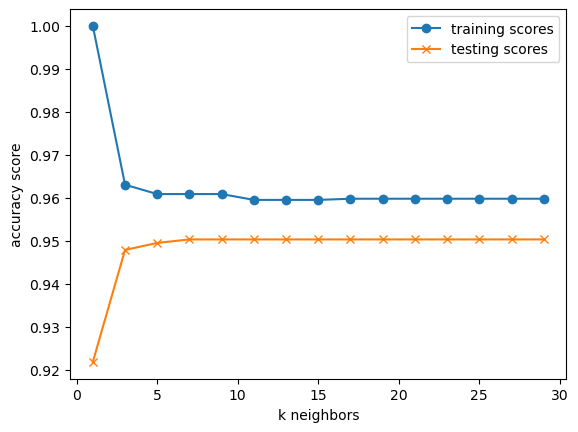

In [52]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
# Plot the results
plt.plot(range(1, 30, 2), train_scores, marker='o', label="training scores")
plt.plot(range(1, 30, 2), test_scores, marker="x", label="testing scores")
plt.xlabel("k neighbors")
plt.ylabel("accuracy score")
plt.legend()
plt.show()

In [53]:
# Train the KNN model with the best k value
# Note that k: 5 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
print('k=5 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=5 Test Acc: 0.950
